In [1]:
# ===============================
# Cell 1 — Imports & Global Config
# ===============================
import os, json, math, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 140
sns.set_context("notebook")

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Paths
DATA_PATH  = "data/housing_adequacy_dataset.csv"   # must contain: quarter, province, hai, dwelling_starts, pop_change_q, needed_units_q

# Split
CUTOFF_DATE = "2018-12-31"  # train ≤ cutoff, test > cutoff

# Models (trim if runtime is long)
ALL_MODELS = ["lr", "rf", "ridge", "xgb", "etr"]

# ===============================
# Choose prediction target here:
# "next_quarter"            -> H=1
# "same_quarter_next_year"  -> H=4
# ===============================
PREDICTION_CHOICE = "same_quarter_next_year"  # or "next_quarter"

# ===============================
# Optional smoothing settings
# ===============================
USE_SMOOTH_FEATURES   = True   # add smoothed lag features to stabilize training (recommended for spiky HAI)
PREDICT_SMOOTH_TARGET = False  # if True, the model predicts smoothed HAI itself (usually leave False)
SMOOTH_WINDOW         = 4      # causal window (quarters). 4≈yearly smoothing
SMOOTH_FUNC           = "median"  # "median" (robust) or "mean"


In [2]:
# ===============================
# Cell 2 — Helpers: causal smoothing
# ===============================
def causal_roll(series: pd.Series, window: int, how: str = "median") -> pd.Series:
    """
    Causal (one-sided) rolling aggregator. No look-ahead.
    """
    if how == "median":
        return series.rolling(window=window, min_periods=1).median()
    elif how == "mean":
        return series.rolling(window=window, min_periods=1).mean()
    else:
        raise ValueError("how must be 'median' or 'mean'")


In [3]:
# ===============================
# Cell 3 — Build Modeling Frame (create lags + causal smoothing)
# ===============================
def build_model_frame_hai(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a modeling DataFrame for HAI with all useful lags and (optional) causal smoothing.
    Required columns in df: quarter, province, hai, dwelling_starts, pop_change_q, needed_units_q
    """
    df = df.sort_values(["province", "quarter"]).copy()
    df["quarter"] = pd.PeriodIndex(df["quarter"], freq="Q").to_timestamp()

    # Raw target
    df["hai_raw"] = df["hai"].astype(float)

    # Causal smoothed HAI (no leakage)
    df["hai_roll"] = (
        df.groupby("province")["hai_raw"]
          .transform(lambda s: causal_roll(s, SMOOTH_WINDOW, SMOOTH_FUNC))
    )

    # Which series to use as the supervised target
    df["y"] = df["hai_roll"] if PREDICT_SMOOTH_TARGET else df["hai_raw"]

    # y lags (raw and smoothed) — we’ll pick leak-safe ones later
    for L in [1, 2, 3, 4, 8]:
        df[f"hai_raw_lag{L}"]  = df.groupby("province")["hai_raw"].shift(L)
        df[f"hai_roll_lag{L}"] = df.groupby("province")["hai_roll"].shift(L)

    # Exogenous lags (we’ll pick per horizon)
    for L in [1, 4, 8]:
        for col in ["dwelling_starts", "pop_change_q", "needed_units_q"]:
            df[f"{col}_lag{L}"] = df.groupby("province")[col].shift(L)

    # Quarter dummies (no leakage)
    qdum = pd.get_dummies(df["quarter"].dt.quarter, prefix="q")
    if "q_1" in qdum:
        qdum = qdum.drop(columns=["q_1"])
    df = pd.concat([df, qdum], axis=1)

    return df


In [4]:
# ===============================
# Cell 4 — Feature selection per horizon (leak-safe)
# ===============================
def features_for_choice_hai(choice: str):
    """
    Leak-safe features for HAI prediction.
    - next_quarter (H=1): allow lag1; include smoothed lag1 as feature if enabled
    - same_quarter_next_year (H=4): use lag>=4; include smoothed lag4
    """
    choice = choice.lower()
    feats = []
    if choice == "next_quarter":
        H = 1
        feats = [
            "hai_raw_lag1",
            "dwelling_starts_lag1", "pop_change_q_lag1", "needed_units_q_lag1",
            "hai_raw_lag4",  # seasonal memory
        ]
        if USE_SMOOTH_FEATURES:
            feats += ["hai_roll_lag1", "hai_roll_lag4"]
    elif choice == "same_quarter_next_year":
        H = 4
        feats = [
            "hai_raw_lag4", "hai_raw_lag8",
            "dwelling_starts_lag4", "pop_change_q_lag4", "needed_units_q_lag4",
        ]
        if USE_SMOOTH_FEATURES:
            feats += ["hai_roll_lag4", "hai_roll_lag8"]
    else:
        raise ValueError("choice must be 'next_quarter' or 'same_quarter_next_year'")

    # Optional: add seasonal dummies
    # feats += ["q_2","q_3","q_4"]

    return H, feats


In [5]:
# ===============================
# Cell 5 — Splits, Metrics, Rolling
# ===============================
def chrono_split(df, cutoff):
    cutoff = pd.Timestamp(cutoff)
    tr = df[df["quarter"] <= cutoff].copy()
    te = df[df["quarter"] >  cutoff].copy()
    return tr, te

def rolling_split(df, initial=None, step=1, fh=1):
    df = df.copy()
    df["quarter"] = pd.to_datetime(df["quarter"], errors="coerce")
    dates = pd.Index(df["quarter"].dropna().unique()).sort_values()
    if len(dates) == 0:
        return
    if initial is None:
        initial = dates[int(0.6 * len(dates))]
    else:
        initial = pd.Timestamp(initial)
    start_idx = dates.get_indexer([initial], method="ffill")[0]
    start_idx = max(start_idx, 0)
    for i in range(start_idx, len(dates) - fh, step):
        train_end = dates[i]
        test_slice = dates[i+1 : i+1+fh]
        tr = df[df["quarter"] <= train_end].copy()
        te = df[df["quarter"].isin(test_slice)].copy()
        if not te.empty:
            yield tr, te

def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    eps = 1e-8
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps))
    return {"MAE": mae, "RMSE": rmse, "sMAPE": smape}

def _naive_mae_train(y_train: pd.Series, season: int = 1, eps: float = 1e-12) -> float:
    y = y_train.to_numpy()
    if len(y) <= season:
        return np.nan
    denom = np.mean(np.abs(y[season:] - y[:-season]))
    return max(denom, eps)


In [6]:
# ===============================
# Cell 6 — Model factory & param spaces (same as before)
# ===============================
def make_model(name, **kw):
    if name == "lr":
        model = LinearRegression()
    elif name == "ridge":
        model = Pipeline([("scaler", StandardScaler()), ("est", Ridge())])
    elif name == "lasso":
        model = Pipeline([("scaler", StandardScaler()), ("est", Lasso(max_iter=20000))])
    elif name == "enet":
        model = Pipeline([("scaler", StandardScaler()), ("est", ElasticNet(max_iter=20000))])
    elif name == "rf":
        model = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
    elif name == "etr":
        model = ExtraTreesRegressor(n_jobs=-1, random_state=RANDOM_STATE)
    elif name == "gbr":
        model = GradientBoostingRegressor(random_state=RANDOM_STATE)
    elif name == "svr":
        model = Pipeline([("scaler", StandardScaler()), ("est", SVR())])
    elif name == "xgb":
        model = XGBRegressor(tree_method="hist", n_estimators=400, learning_rate=0.05, random_state=RANDOM_STATE)
    else:
        raise ValueError(f"Unknown model: {name}")
    if kw:
        model.set_params(**kw)
    return model

PARAM_SPACE = {
    "lr":   {},
    "ridge": {"est__alpha": np.logspace(-2, 2, 9)},
    "lasso": {"est__alpha": np.logspace(-3, 0.5, 8)},
    "enet":  {"est__alpha": np.logspace(-3, 0.5, 6), "est__l1_ratio": [0.2, 0.5, 0.8]},
    "rf":   {"n_estimators": [200, 400], "max_depth": [None, 8], "min_samples_split": [2, 5],
             "min_samples_leaf": [1, 2], "max_features": ["sqrt", 0.8]},
    "etr":  {"n_estimators": [400, 800], "max_depth": [None, 10], "min_samples_split": [2, 5],
             "min_samples_leaf": [1, 2], "max_features": ["sqrt", 0.8]},
    "gbr":  {"n_estimators": [300, 600], "learning_rate": [0.03, 0.1], "max_depth": [2, 3], "subsample": [0.85, 1.0]},
    "svr":  {"est__C": [0.3, 1, 3, 10], "est__epsilon": [0.01, 0.1, 0.3], "est__gamma": ["scale"]},
    "xgb":  {"max_depth": [3, 6], "min_child_weight": [1, 4], "subsample": [0.8, 1.0], "colsample_bytree": [0.8, 1.0]},
}


In [7]:
# ===============================
# Cell 7 — Tuning utils + caching (cache key includes choice + smoothing flags)
# ===============================
def sample_param_grid(space: dict, n_iter: int, rng: np.random.RandomState):
    if not space:
        return [dict()]
    keys = list(space.keys())
    samples = []
    for _ in range(n_iter):
        d = {}
        for k in keys:
            v = space[k]
            if isinstance(v, (list, tuple, np.ndarray)):
                d[k] = v[rng.randint(0, len(v))]
            else:
                d[k] = v
        samples.append(d)
    return samples

def rolling_score_one_fold(model, tr, te, features, season=1):
    Xtr, ytr = tr[features], tr["y"]
    Xte, yte = te[features], te["y"]
    model.fit(Xtr, ytr)
    ypred = model.predict(Xte)
    denom = _naive_mae_train(ytr, season=season)
    mae = mean_absolute_error(yte, ypred)
    return mae / denom

def tune_model_for_province(df, features, model_name, n_iter=20, fh=1, initial=None,
                            season=1, random_state=RANDOM_STATE):
    space = PARAM_SPACE[model_name]
    rng = np.random.RandomState(random_state)
    candidates = sample_param_grid(space, n_iter=n_iter, rng=rng)

    scores = []
    for params in candidates:
        fold_scores = []
        for tr, te in rolling_split(df, initial=initial, fh=fh):
            m = make_model(model_name, **params)
            try:
                s = rolling_score_one_fold(m, tr, te, features, season=season)
                if np.isfinite(s):
                    fold_scores.append(s)
            except Exception:
                pass
        score = np.mean(fold_scores) if len(fold_scores) else np.inf
        scores.append((params, score))
    scores.sort(key=lambda x: x[1])
    best_params, best_score = scores[0]
    return best_params, best_score, scores

def tune_all_models_per_province(train_df, features, models_to_run, n_iter=20, fh=1,
                                 initial=None, season=1, random_state=RANDOM_STATE):
    best_params = {}
    provinces = list(train_df["province"].unique())
    total_tasks = len(provinces) * len(models_to_run)
    task = 0
    print(f"🧮 Tuning: {len(provinces)} prov × {len(models_to_run)} models × {n_iter} trials (fh={fh}, season={season})")
    for prov, gtr in train_df.groupby("province"):
        for name in models_to_run:
            task += 1
            print(f"→ [{task}/{total_tasks}] {prov.upper()} — {name.upper()} ...", end=" ", flush=True)
            bp, bs, _ = tune_model_for_province(
                df=gtr, features=features, model_name=name, n_iter=n_iter, fh=fh,
                initial=initial, season=season, random_state=random_state
            )
            best_params[(prov, name)] = bp
            print(f"best MASE={bs:.3f}")
    print("✅ Tuning done.")
    return best_params

def cache_path_for_hai(choice: str) -> str:
    tag = "h1" if choice == "next_quarter" else "h4"
    smooth_tag = f"s{SMOOTH_WINDOW}_{SMOOTH_FUNC}"
    feat_tag = "featS" if USE_SMOOTH_FEATURES else "featN"
    targ_tag = "tSm" if PREDICT_SMOOTH_TARGET else "tRaw"
    return f"best_params_cache_hai_{tag}_{smooth_tag}_{feat_tag}_{targ_tag}.json"

def load_or_tune_best_params(train_df, features, models_to_run,
                             prediction_choice: str,
                             n_iter=8, fh=1, initial=None):
    cache_path = cache_path_for_hai(prediction_choice)
    if os.path.exists(cache_path):
        print(f"🔁 Loading cached best parameters from {cache_path}")
        with open(cache_path, "r") as f:
            best_params = json.load(f)
        best_params = {tuple(k.split("|")): v for k, v in best_params.items()}
        return best_params
    else:
        print("⏳ Running tuning from scratch...")
        season = 1 if prediction_choice == "next_quarter" else 4
        best_params = tune_all_models_per_province(
            train_df=train_df,
            features=features,
            models_to_run=models_to_run,
            n_iter=n_iter,
            fh=fh,
            initial=initial,
            season=season,
            random_state=RANDOM_STATE
        )
        best_params_str = {"|".join(k): v for k, v in best_params.items()}
        with open(cache_path, "w") as f:
            json.dump(best_params_str, f, indent=2)
        print(f"✅ Saved tuned best parameters to {cache_path}")
        return best_params


In [8]:
# ===============================
# Cell 8 — Fit (TRAIN) + Predict (TEST) + Viz
# ===============================
def fit_predict_holdout_per_province(train_df, test_df, features, models_to_run, best_params,
                                     prediction_choice: str):
    season = 1 if prediction_choice == "next_quarter" else 4
    rows = []
    for prov, gtr in train_df.groupby("province"):
        gte = test_df[test_df["province"] == prov]
        if gte.empty:
            continue
        for name in models_to_run:
            params = best_params.get((prov, name), {})
            m = make_model(name, **params)
            Xtr, ytr = gtr[features], gtr["y"]
            Xte, yte = gte[features], gte["y"]
            m.fit(Xtr, ytr)
            ypred = m.predict(Xte)

            res = metrics(yte, ypred)
            denom = _naive_mae_train(ytr, season=season)
            res["MASE"] = res["MAE"] / denom

            for q, yt, yp in zip(gte["quarter"].values, yte.values, ypred):
                rows.append({
                    "province": prov, "model": name,
                    "quarter": pd.to_datetime(q), "y_true": yt, "y_pred": yp,
                    **res
                })
    return pd.DataFrame(rows)

def summarize_metrics_table(preds_df: pd.DataFrame):
    g_model = (preds_df.groupby("model")[["MAE","RMSE","sMAPE","MASE"]]
               .mean().round(3).sort_values("MAE"))
    display(g_model)
    g_pm = (preds_df.groupby(["province","model"])[["MAE","RMSE","sMAPE","MASE"]]
            .mean().round(3))
    return g_model, g_pm

def plot_holdout_overlay(preds_df, models_to_run, suptitle="HAI — True vs Predicted (Holdout)"):
    provs = sorted(preds_df["province"].unique())
    cols = 4
    rows = math.ceil(len(provs) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 2.6*rows), sharex=False, sharey=False)
    axes = axes.ravel()

    for i, prov in enumerate(provs):
        ax = axes[i]
        g = preds_df[preds_df["province"] == prov].copy()
        truth = g.drop_duplicates("quarter")[["quarter","y_true"]].sort_values("quarter")
        ax.plot(truth["quarter"], truth["y_true"], color="black", lw=1.8, alpha=.55, label="True")

        for name in models_to_run:
            gm = g[g["model"] == name].sort_values("quarter")
            if gm.empty: continue
            ax.plot(gm["quarter"], gm["y_pred"], "--", lw=1.5, label=name.upper())

        ax.set_title(prov.upper(), fontsize=10)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid(True, linestyle="--", alpha=0.3)

    for j in range(i+1, rows*cols):
        fig.delaxes(axes[j])
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=min(2+len(models_to_run), 6),
               frameon=False, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle(suptitle, y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()


In [9]:
# ===============================
# Cell 9 — Rolling overlays (latest & stitched)
# ===============================
def rolling_evolution_overlay(df_all, features, best_params, models_to_plot,
                              fh=1, initial=None, show_history=False, step=1, last_k_cutoffs=None,
                              return_df=False):
    models_to_plot = [m.lower() for m in models_to_plot]
    rows = []
    folds = list(rolling_split(df_all, initial=initial, fh=fh, step=step))
    if last_k_cutoffs is not None and len(folds) > last_k_cutoffs:
        folds = folds[-last_k_cutoffs:]

    for tr, te in folds:
        cutoff = pd.to_datetime(tr["quarter"].max())
        for prov, gtr in tr.groupby("province"):
            gte = te[te["province"] == prov]
            if gte.empty: continue
            gtr_ = gtr.dropna(subset=features + ["y"])
            gte_ = gte.dropna(subset=features + ["y"])
            if gtr_.empty or gte_.empty: continue
            Xtr, ytr = gtr_[features], gtr_["y"]
            Xte, yte = gte_[features], gte_["y"]
            for name in models_to_plot:
                params = best_params.get((prov, name), {})
                try:
                    m = make_model(name, **params)
                    m.fit(Xtr, ytr)
                    yhat = m.predict(Xte)
                    if not np.isfinite(yhat).any(): continue
                    rows.append(pd.DataFrame({
                        "cutoff": cutoff, "province": prov, "model": name,
                        "quarter": pd.to_datetime(gte_["quarter"].values),
                        "y_true": yte.values, "y_pred": yhat,
                    }))
                except Exception:
                    continue

    if not rows:
        print("No rolling predictions generated.")
        return None if return_df else None

    df = pd.concat(rows, ignore_index=True).sort_values(["province","model","cutoff","quarter"])
    cuts = sorted(df["cutoff"].unique())
    cut_rank = {c:i for i,c in enumerate(cuts)}
    df["cut_rank"] = df["cutoff"].map(cut_rank)

    # Plot latest-only overlay
    provs = sorted(df["province"].unique())
    cols = 4
    rows_n = math.ceil(len(provs)/cols)
    fig, axes = plt.subplots(rows_n, cols, figsize=(4*cols, 2.6*rows_n), sharex=False, sharey=False)
    axes = axes.ravel()
    palette = plt.rcParams['axes.prop_cycle'].by_key().get('color', None) or ["C0","C1","C2","C3","C4","C5"]
    model_colors = {m: palette[i % len(palette)] for i, m in enumerate(models_to_plot)}

    for i, prov in enumerate(provs):
        ax = axes[i]
        g = df[df["province"] == prov]
        truth = g.drop_duplicates("quarter")[["quarter","y_true"]].sort_values("quarter")
        ax.plot(truth["quarter"], truth["y_true"], color="black", lw=1.4, alpha=.45, label="True")
        for m in models_to_plot:
            gm = g[g["model"] == m]
            if gm.empty: continue
            c = model_colors[m]
            if show_history:
                for cu, gc in gm.groupby("cutoff"):
                    ax.plot(gc["quarter"], gc["y_pred"], "--", color=c, alpha=0.25 + 0.6*cut_rank[cu]/max(len(cuts)-1,1), lw=1.0)
            latest_cut = gm["cutoff"].max()
            gl = gm[gm["cutoff"] == latest_cut].sort_values("quarter")
            if not gl.empty:
                ax.plot(gl["quarter"], gl["y_pred"], "--", color=c, lw=1.8, label=m.upper())
        ax.set_title(prov.upper(), fontsize=10)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid(True, linestyle="--", alpha=0.3)

    for j in range(i+1, rows_n*cols):
        fig.delaxes(axes[j])
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=min(2+len(models_to_plot), 6),
               frameon=False, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle("HAI — Rolling forecast overlay (latest cutoff)", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

    if return_df:
        return df

def latest_per_quarter(df_preds):
    return (df_preds.sort_values(["province","model","quarter","cutoff"])
                   .drop_duplicates(["province","model","quarter"], keep="last")
                   .sort_values(["province","model","quarter"]))

def rolling_overlay_lines(df_preds, models_to_plot):
    models_to_plot = [m.lower() for m in models_to_plot]
    df = df_preds.copy()
    df["model"] = df["model"].str.lower()

    provs = sorted(df["province"].unique())
    cols = 4
    rows_n = math.ceil(len(provs)/cols)
    fig, axes = plt.subplots(rows_n, cols, figsize=(4*cols, 2.6*rows_n), sharex=False, sharey=False)
    axes = axes.ravel()

    palette = plt.rcParams['axes.prop_cycle'].by_key().get('color', ["C0","C1","C2","C3","C4","C5"])
    model_colors = {m: palette[i % len(palette)] for i, m in enumerate(models_to_plot)}
    model_styles = {m: s for m, s in zip(models_to_plot, ["--","-.",":",(0,(3,1,1,1)),(0,(5,1))])}

    for i, prov in enumerate(provs):
        ax = axes[i]
        g = df[df["province"] == prov]
        truth = g.drop_duplicates("quarter")[["quarter","y_true"]].sort_values("quarter")
        ax.plot(truth["quarter"], truth["y_true"], color="black", lw=1.3, alpha=.45, label="True")
        for m in models_to_plot:
            gl = g[g["model"] == m].sort_values("quarter")
            if gl.empty: continue
            ax.plot(gl["quarter"], gl["y_pred"],
                    linestyle=model_styles[m], color=model_colors[m],
                    marker="o", markersize=2.2, lw=1.5, label=m.upper())
        ax.set_title(prov.upper(), fontsize=10)
        ax.tick_params(axis="x", labelrotation=45)
        ax.grid(True, ls="--", alpha=.3)

    for j in range(i+1, rows_n*cols):
        fig.delaxes(axes[j])
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center",
               ncol=min(2+len(models_to_plot), 6), frameon=False, bbox_to_anchor=(0.5, -0.02))
    fig.suptitle("HAI — Rolling forecast (stitched latest per quarter)", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()


Mode: same_quarter_next_year | H=4 | season=4
Features: ['hai_raw_lag4', 'hai_raw_lag8', 'dwelling_starts_lag4', 'pop_change_q_lag4', 'needed_units_q_lag4', 'hai_roll_lag4', 'hai_roll_lag8']
Train: 1992-01-01 → 2018-10-01 | Test: 2019-01-01 → 2025-07-01
⏳ Running tuning from scratch...
🧮 Tuning: 11 prov × 5 models × 8 trials (fh=4, season=4)
→ [1/55] AB — LR ... best MASE=1.283
→ [2/55] AB — RF ... best MASE=1.180
→ [3/55] AB — RIDGE ... best MASE=1.196
→ [4/55] AB — XGB ... best MASE=1.267
→ [5/55] AB — ETR ... best MASE=1.184
→ [6/55] BC — LR ... best MASE=1.313
→ [7/55] BC — RF ... best MASE=1.290
→ [8/55] BC — RIDGE ... best MASE=1.254
→ [9/55] BC — XGB ... best MASE=1.389
→ [10/55] BC — ETR ... best MASE=1.300
→ [11/55] CAN — LR ... best MASE=1.544
→ [12/55] CAN — RF ... best MASE=1.457
→ [13/55] CAN — RIDGE ... best MASE=1.378
→ [14/55] CAN — XGB ... best MASE=1.605
→ [15/55] CAN — ETR ... best MASE=1.484
→ [16/55] MB — LR ... best MASE=0.586
→ [17/55] MB — RF ... best MASE=0.683

,MAE,RMSE,sMAPE,MASE
model,,,,
etr,0.985,1.238,75.018,1.356
rf,1.078,1.311,78.666,1.397
lr,1.145,1.480,90.160,1.457
ridge,1.164,1.495,92.387,1.555
xgb,1.218,1.544,84.893,1.523


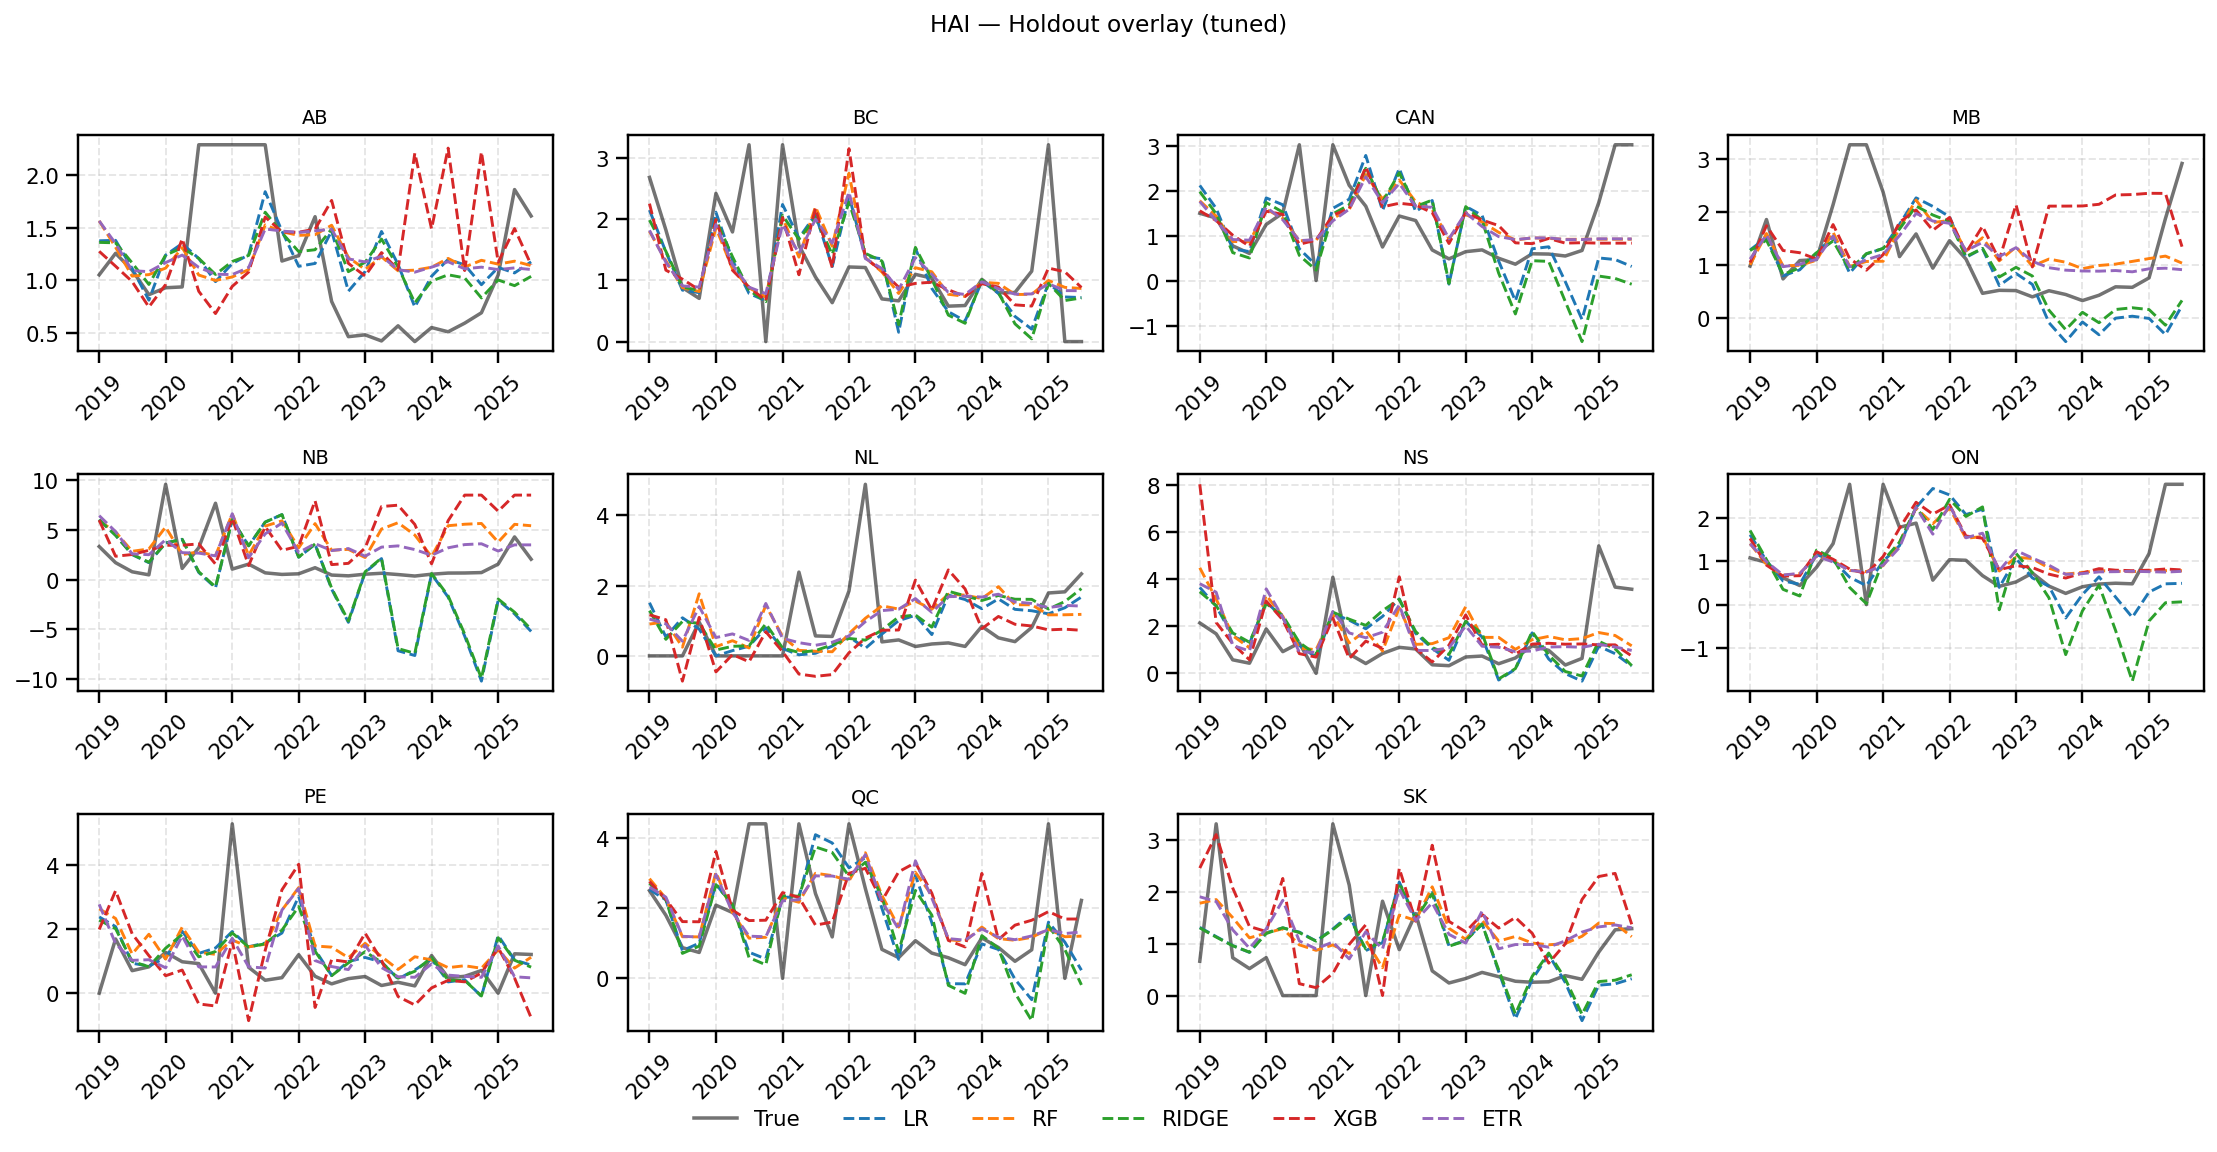

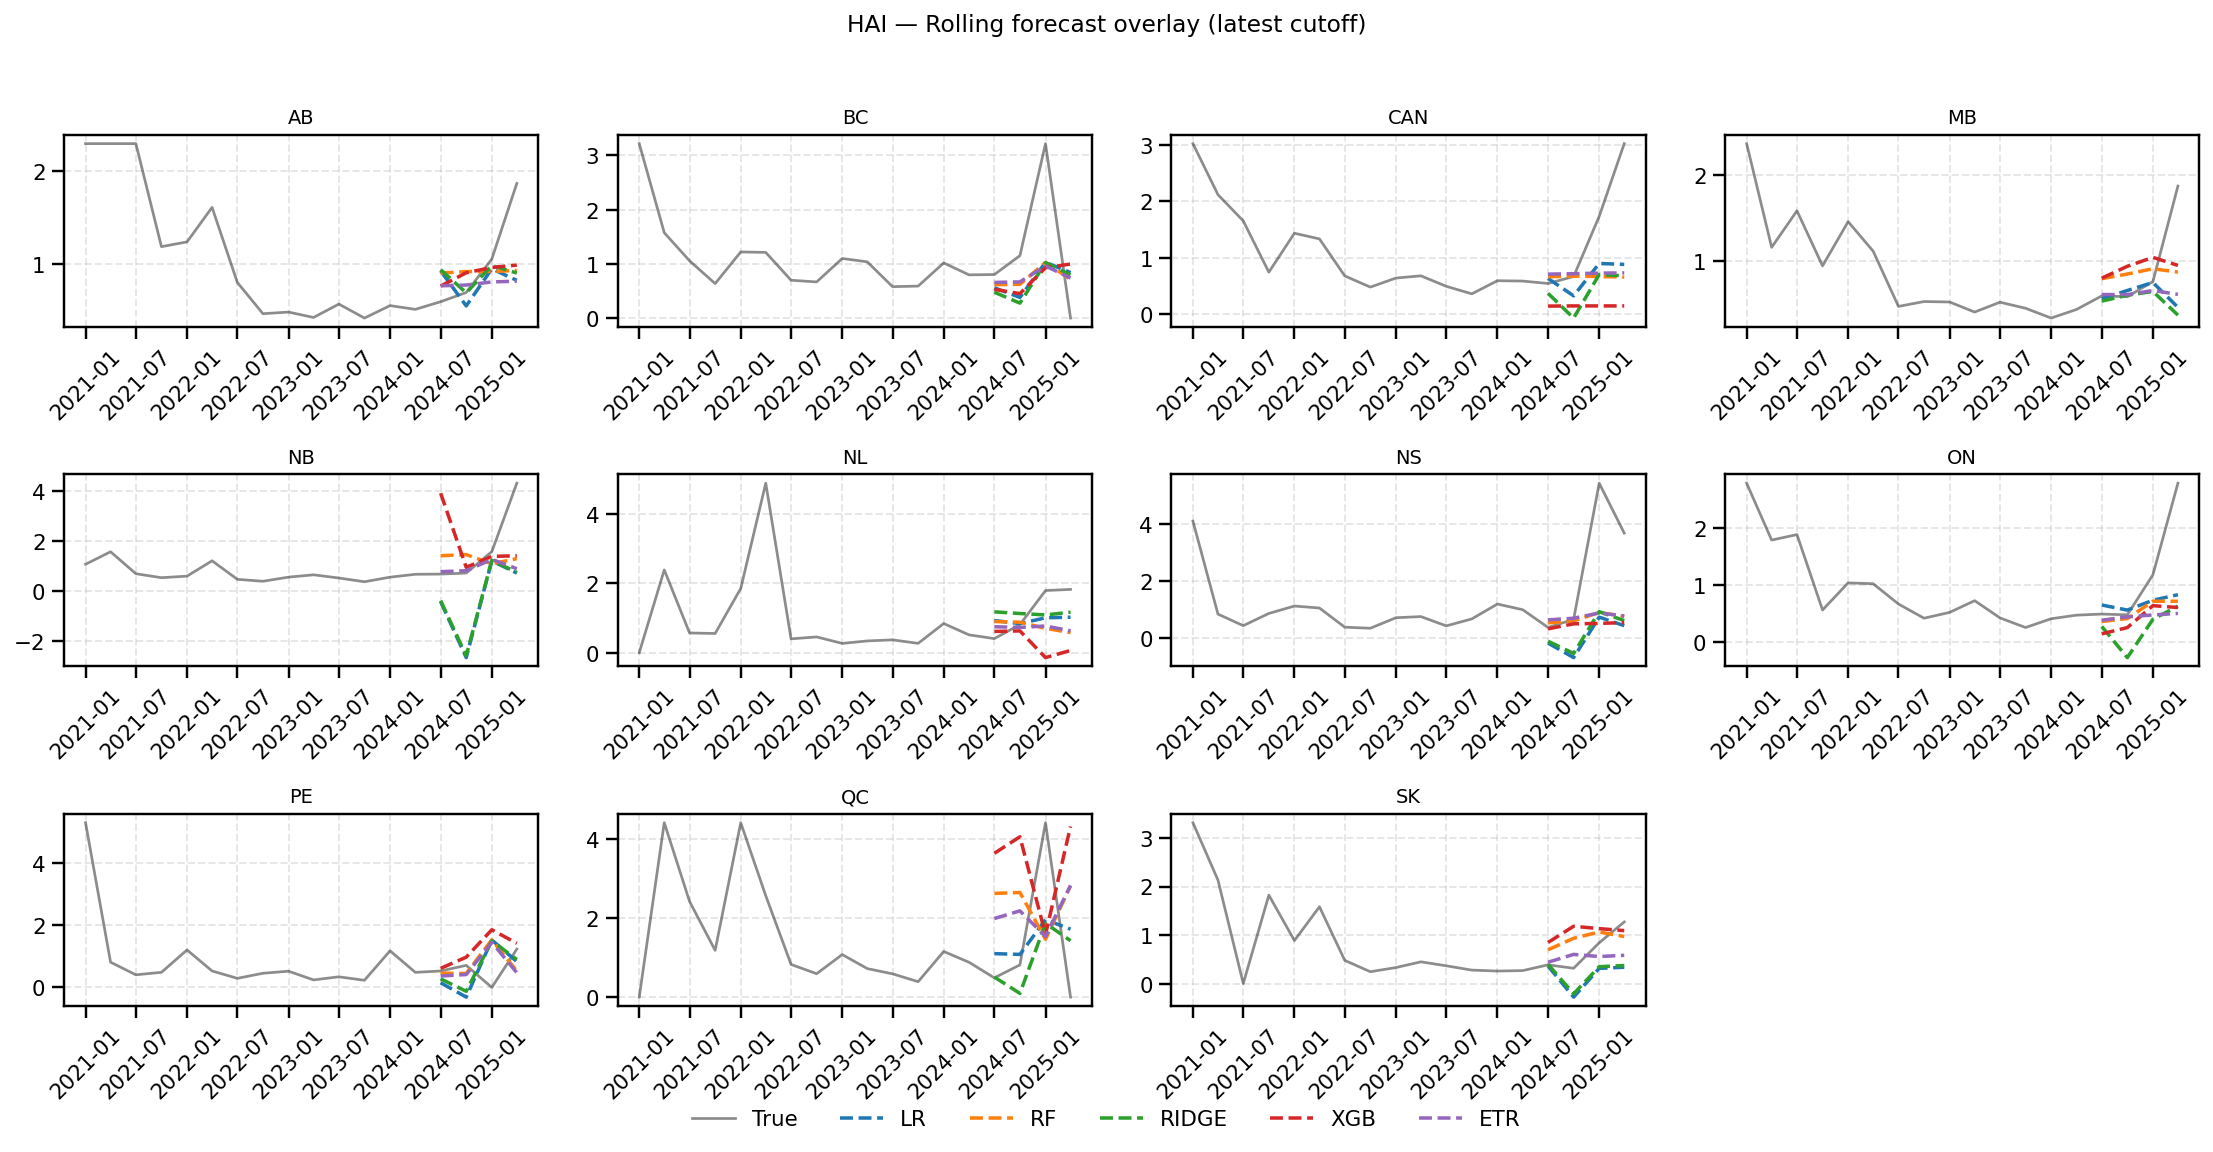

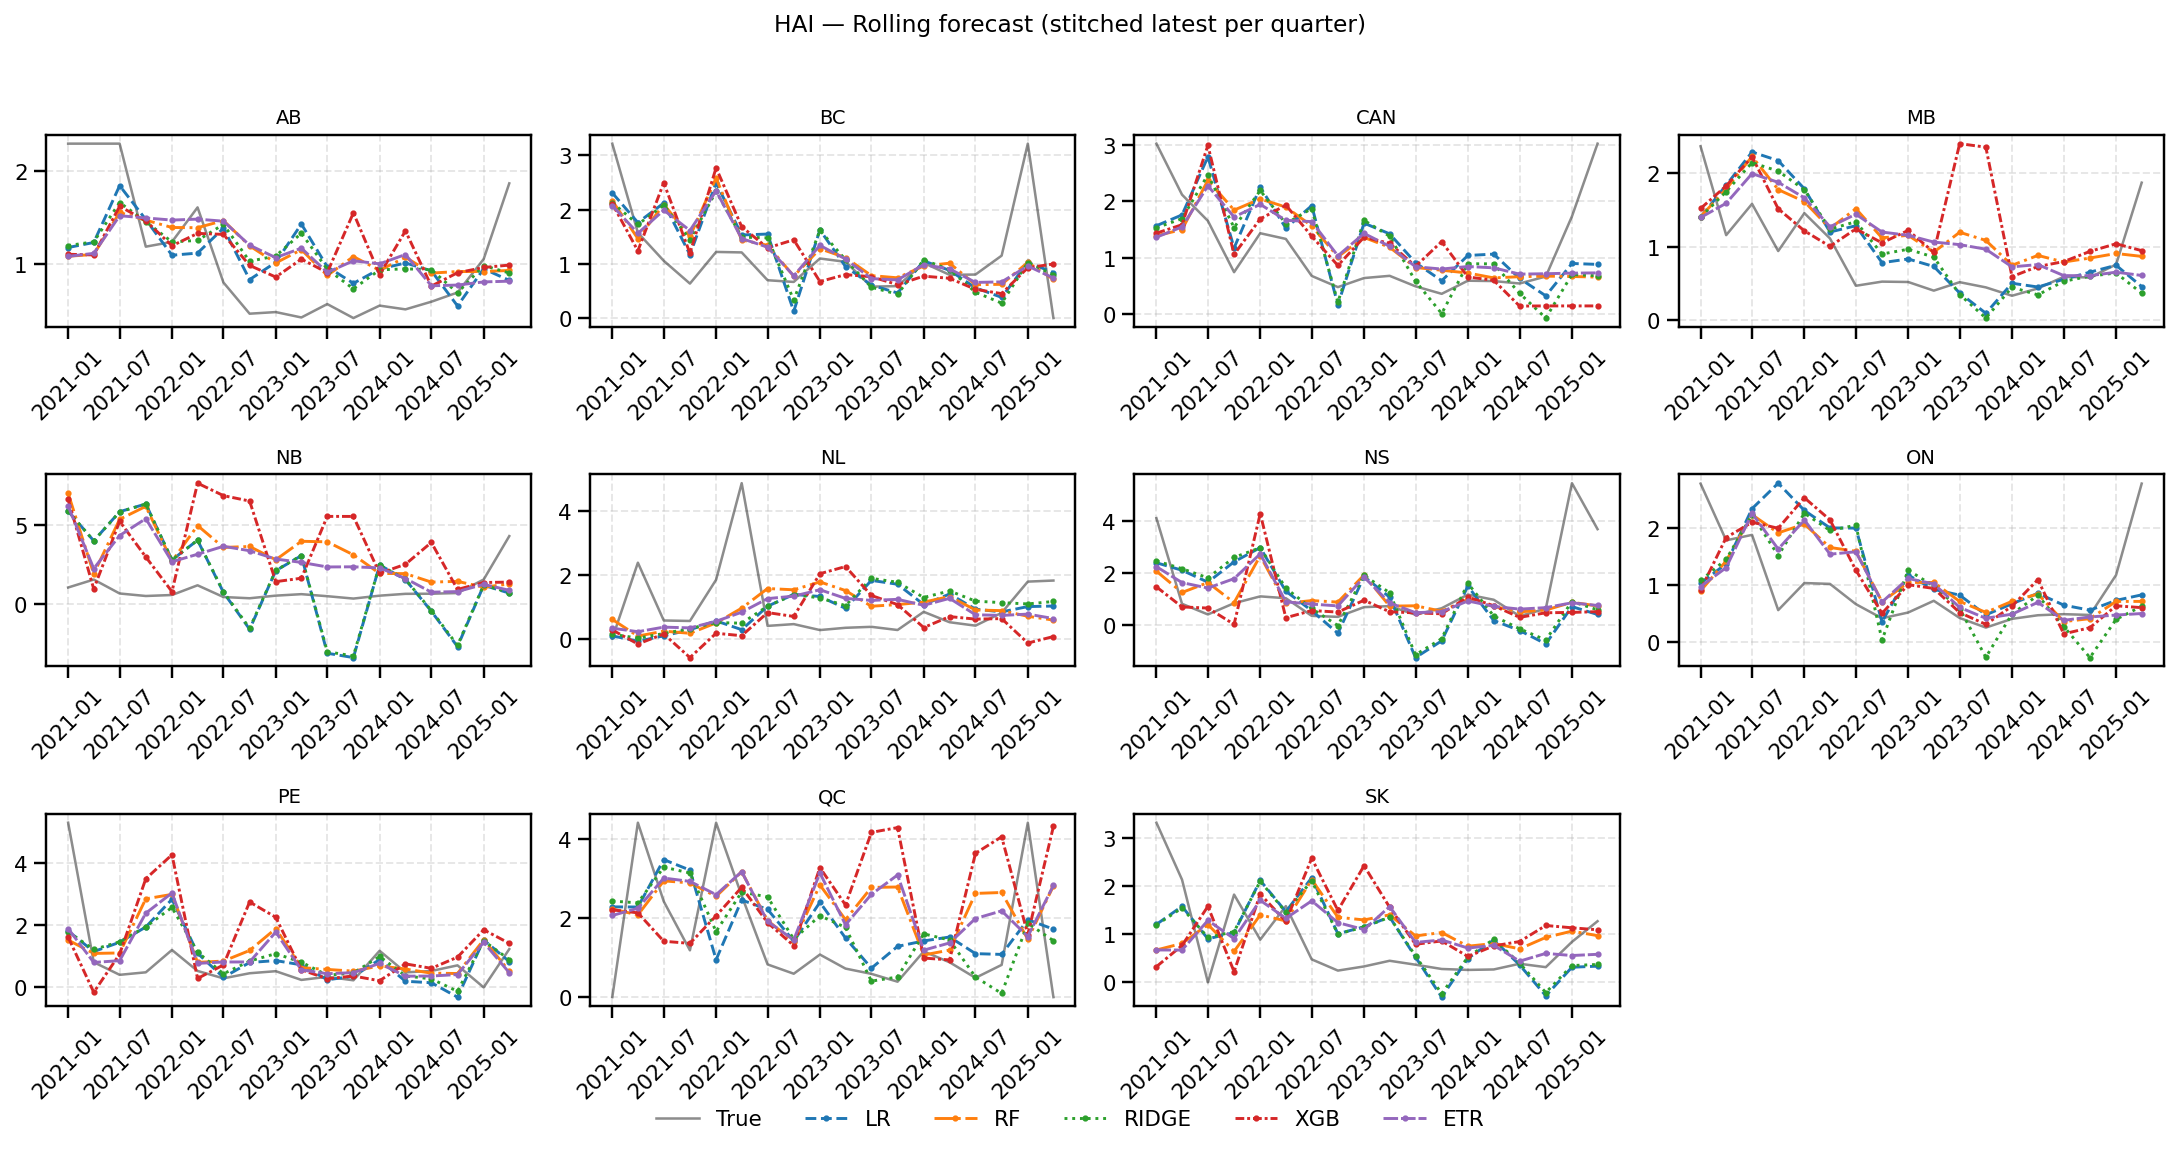

,cutoff,province,model,quarter,y_true,y_pred,cut_rank
16,2020-10-01,ab,etr,2021-01-01,2.292790,1.080554,0
17,2020-10-01,ab,etr,2021-04-01,2.292790,1.112790,0
18,2020-10-01,ab,etr,2021-07-01,2.292790,1.500103,0
19,2020-10-01,ab,etr,2021-10-01,1.184794,1.490863,0
236,2021-04-01,ab,etr,2021-07-01,2.292790,1.517650,1
237,2021-04-01,ab,etr,2021-10-01,1.184794,1.493541,1
238,2021-04-01,ab,etr,2022-01-01,1.236215,1.477497,1
239,2021-04-01,ab,etr,2022-04-01,1.607108,1.488123,1
456,2021-10-01,ab,etr,2022-01-01,1.236215,1.470648,2
457,2021-10-01,ab,etr,2022-04-01,1.607108,1.480855,2


In [10]:
# ===============================
# Cell 10 — Run: load, prep, tune, evaluate, visualize
# ===============================
# 1) Load + frame
raw = pd.read_csv(DATA_PATH)
model_df = build_model_frame_hai(raw)

# 2) Choose horizon & features
H, feat_cols = features_for_choice_hai(PREDICTION_CHOICE)
season = 1 if PREDICTION_CHOICE == "next_quarter" else 4
print(f"Mode: {PREDICTION_CHOICE} | H={H} | season={season}")
print("Features:", feat_cols)

# 3) Drop rows with NaNs in features/target
safe_df = model_df.dropna(subset=feat_cols + ["y"]).copy()

# 4) Holdout split
train, test = chrono_split(safe_df, cutoff=CUTOFF_DATE)
print(f"Train: {train['quarter'].min().date()} → {train['quarter'].max().date()} | "
      f"Test: {test['quarter'].min().date()} → {test['quarter'].max().date()}")

# 5) Tune/load cache (cache name encodes horizon + smoothing settings)
best_params = load_or_tune_best_params(
    train_df=train,
    features=feat_cols,
    models_to_run=ALL_MODELS,
    prediction_choice=PREDICTION_CHOICE,
    n_iter=8,   # increase for deeper search
    fh=H,
    initial=None
)

# 6) Final fit + predict on TEST
preds_holdout = fit_predict_holdout_per_province(
    train_df=train, test_df=test, features=feat_cols,
    models_to_run=ALL_MODELS, best_params=best_params,
    prediction_choice=PREDICTION_CHOICE
)

# 7) Summary & overlay
print("\n=== HAI — Holdout averages across provinces (tuned) ===")
g_model, g_pm = summarize_metrics_table(preds_holdout)
plot_holdout_overlay(preds_holdout, ALL_MODELS, suptitle="HAI — Holdout overlay (tuned)")

# 8) Rolling overlays
preds_roll = rolling_evolution_overlay(
    df_all=safe_df,
    features=feat_cols,
    best_params=best_params,
    models_to_plot=ALL_MODELS,
    fh=H,
    initial="2012-12-31",
    step=2,
    last_k_cutoffs=8,
    show_history=False,
    return_df=True,
)

if preds_roll is not None:
    d_latest = latest_per_quarter(preds_roll)
    rolling_overlay_lines(d_latest, ALL_MODELS)

# peek
preds_roll.head(10) if preds_roll is not None else None


## With smoothing added

In [11]:
# Models (trim if runtime is long)
ALL_MODELS = ["lr", "rf", "ridge", "xgb", "etr"]

# ===============================
# Choose prediction target here:
# "next_quarter"            -> H=1
# "same_quarter_next_year"  -> H=4
# ===============================
PREDICTION_CHOICE = "same_quarter_next_year"  # or "next_quarter"

# ===============================
# Optional smoothing settings
# ===============================
USE_SMOOTH_FEATURES   = True   # add smoothed lag features to stabilize training (recommended for spiky HAI)
PREDICT_SMOOTH_TARGET = True  # if True, the model predicts smoothed HAI itself (usually leave False)
SMOOTH_WINDOW         = 4      # causal window (quarters). 4≈yearly smoothing
SMOOTH_FUNC           = "median"  # "median" (robust) or "mean"


Mode: same_quarter_next_year | H=4 | season=4
Features: ['hai_raw_lag4', 'hai_raw_lag8', 'dwelling_starts_lag4', 'pop_change_q_lag4', 'needed_units_q_lag4', 'hai_roll_lag4', 'hai_roll_lag8']
Train: 1992-01-01 → 2018-10-01 | Test: 2019-01-01 → 2025-07-01
⏳ Running tuning from scratch...
🧮 Tuning: 11 prov × 5 models × 8 trials (fh=4, season=4)
→ [1/55] AB — LR ... best MASE=1.461
→ [2/55] AB — RF ... best MASE=1.483
→ [3/55] AB — RIDGE ... best MASE=1.435
→ [4/55] AB — XGB ... best MASE=1.605
→ [5/55] AB — ETR ... best MASE=1.452
→ [6/55] BC — LR ... best MASE=1.161
→ [7/55] BC — RF ... best MASE=1.285
→ [8/55] BC — RIDGE ... best MASE=1.103
→ [9/55] BC — XGB ... best MASE=1.319
→ [10/55] BC — ETR ... best MASE=1.196
→ [11/55] CAN — LR ... best MASE=1.398
→ [12/55] CAN — RF ... best MASE=1.438
→ [13/55] CAN — RIDGE ... best MASE=1.324
→ [14/55] CAN — XGB ... best MASE=1.576
→ [15/55] CAN — ETR ... best MASE=1.296
→ [16/55] MB — LR ... best MASE=0.620
→ [17/55] MB — RF ... best MASE=0.730

,MAE,RMSE,sMAPE,MASE
model,,,,
etr,0.759,0.881,64.157,1.298
rf,0.813,0.957,65.266,1.322
xgb,0.952,1.209,66.374,1.413
ridge,1.024,1.271,68.839,1.323
lr,1.063,1.328,70.860,1.332


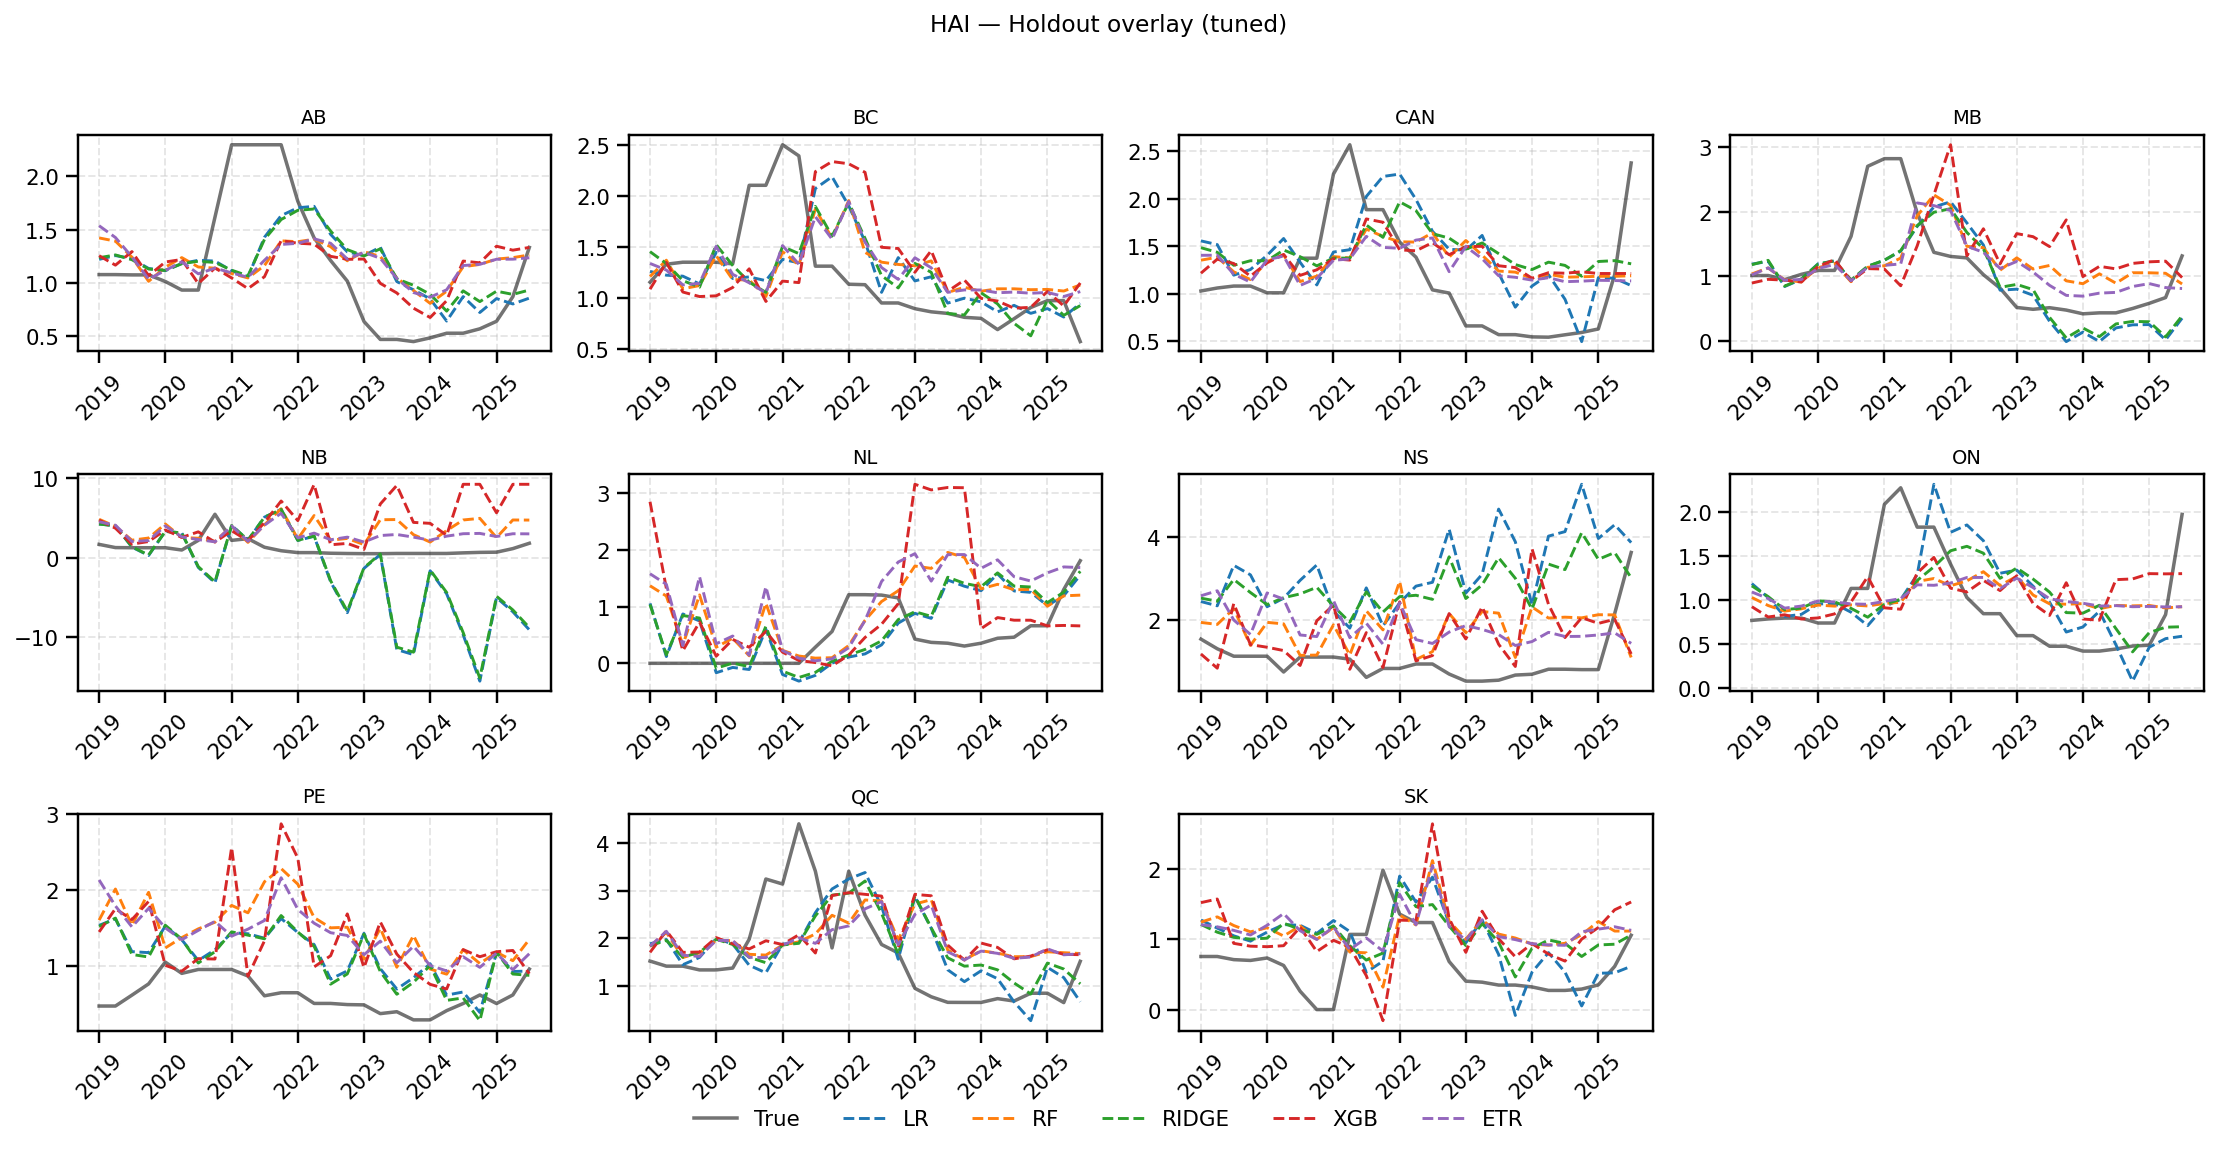

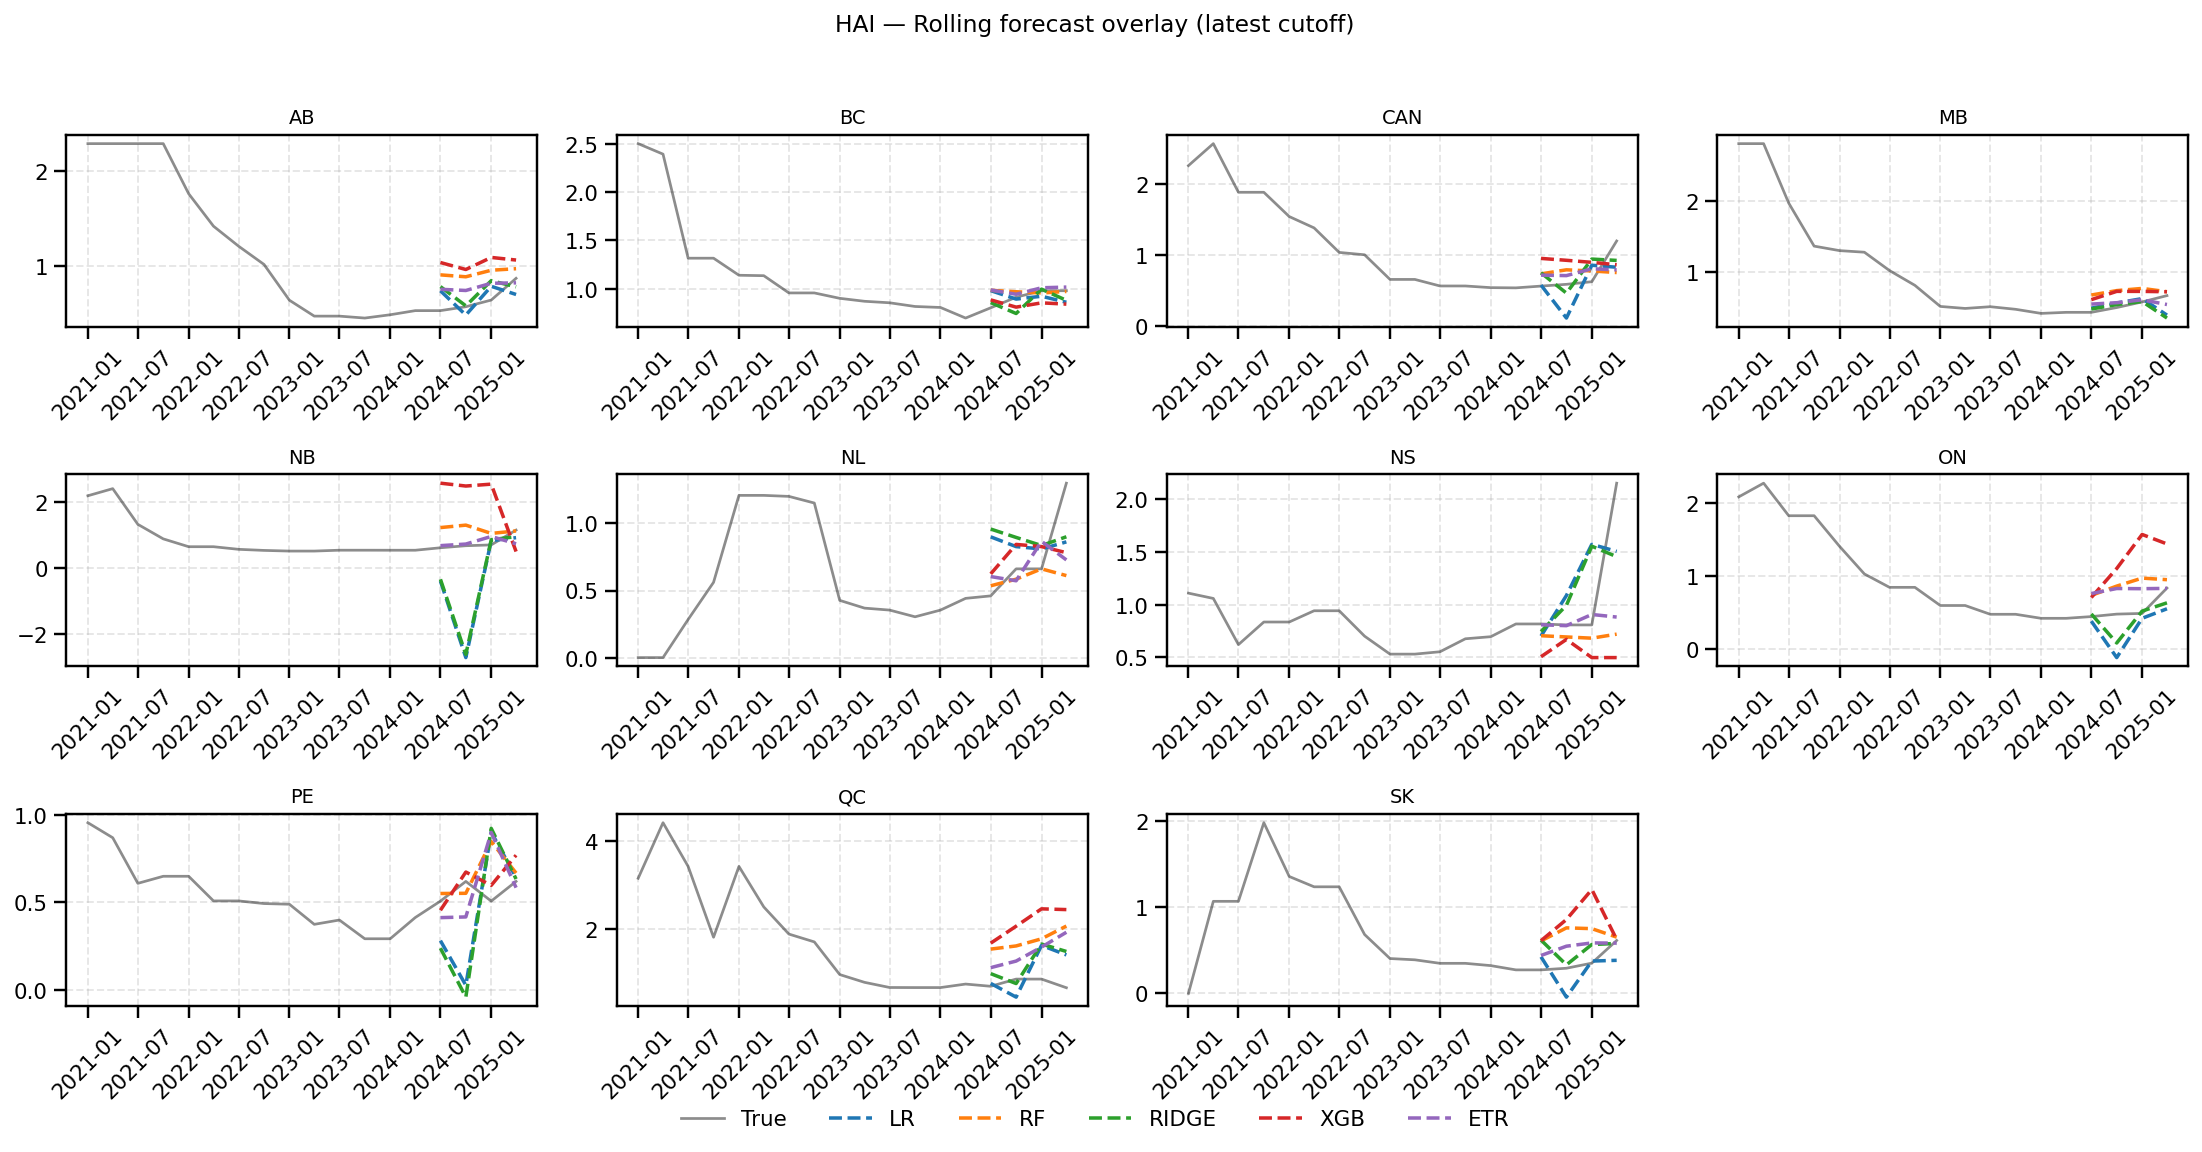

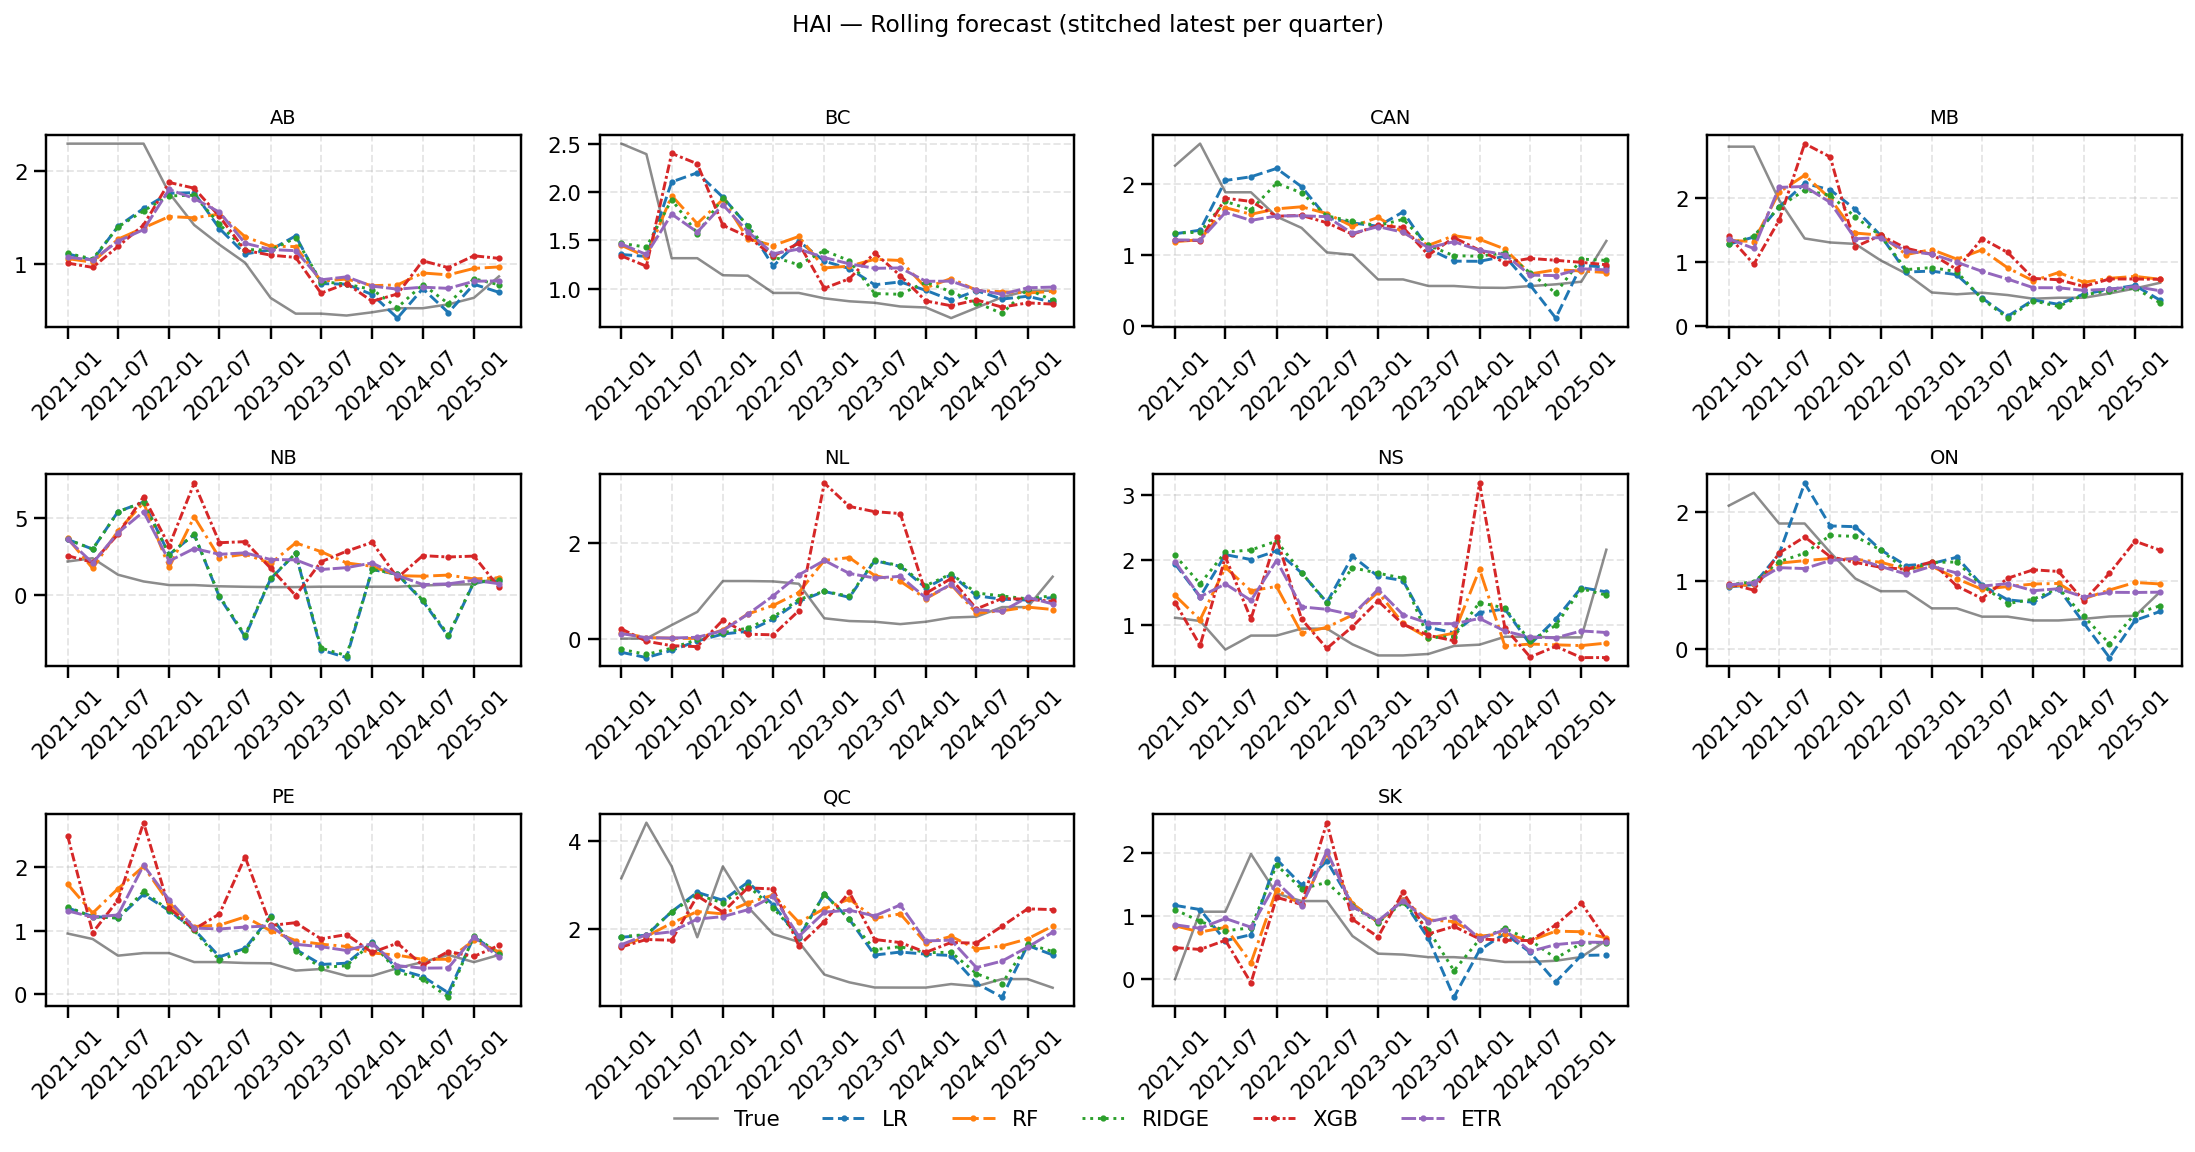

,cutoff,province,model,quarter,y_true,y_pred,cut_rank
16,2020-10-01,ab,etr,2021-01-01,2.292790,1.076694,0
17,2020-10-01,ab,etr,2021-04-01,2.292790,1.046611,0
18,2020-10-01,ab,etr,2021-07-01,2.292790,1.217782,0
19,2020-10-01,ab,etr,2021-10-01,2.292790,1.387037,0
236,2021-04-01,ab,etr,2021-07-01,2.292790,1.248790,1
237,2021-04-01,ab,etr,2021-10-01,2.292790,1.372209,1
238,2021-04-01,ab,etr,2022-01-01,1.764503,1.382455,1
239,2021-04-01,ab,etr,2022-04-01,1.421662,1.410776,1
456,2021-10-01,ab,etr,2022-01-01,1.764503,1.801978,2
457,2021-10-01,ab,etr,2022-04-01,1.421662,1.704978,2


In [12]:
# ===============================
# Cell 10 — Run: load, prep, tune, evaluate, visualize
# ===============================
# 1) Load + frame
raw = pd.read_csv(DATA_PATH)
model_df = build_model_frame_hai(raw)

# 2) Choose horizon & features
H, feat_cols = features_for_choice_hai(PREDICTION_CHOICE)
season = 1 if PREDICTION_CHOICE == "next_quarter" else 4
print(f"Mode: {PREDICTION_CHOICE} | H={H} | season={season}")
print("Features:", feat_cols)

# 3) Drop rows with NaNs in features/target
safe_df = model_df.dropna(subset=feat_cols + ["y"]).copy()

# 4) Holdout split
train, test = chrono_split(safe_df, cutoff=CUTOFF_DATE)
print(f"Train: {train['quarter'].min().date()} → {train['quarter'].max().date()} | "
      f"Test: {test['quarter'].min().date()} → {test['quarter'].max().date()}")

# 5) Tune/load cache (cache name encodes horizon + smoothing settings)
best_params = load_or_tune_best_params(
    train_df=train,
    features=feat_cols,
    models_to_run=ALL_MODELS,
    prediction_choice=PREDICTION_CHOICE,
    n_iter=8,   # increase for deeper search
    fh=H,
    initial=None
)

# 6) Final fit + predict on TEST
preds_holdout = fit_predict_holdout_per_province(
    train_df=train, test_df=test, features=feat_cols,
    models_to_run=ALL_MODELS, best_params=best_params,
    prediction_choice=PREDICTION_CHOICE
)

# 7) Summary & overlay
print("\n=== HAI — Holdout averages across provinces (tuned) ===")
g_model, g_pm = summarize_metrics_table(preds_holdout)
plot_holdout_overlay(preds_holdout, ALL_MODELS, suptitle="HAI — Holdout overlay (tuned)")

# 8) Rolling overlays
preds_roll = rolling_evolution_overlay(
    df_all=safe_df,
    features=feat_cols,
    best_params=best_params,
    models_to_plot=ALL_MODELS,
    fh=H,
    initial="2012-12-31",
    step=2,
    last_k_cutoffs=8,
    show_history=False,
    return_df=True,
)

if preds_roll is not None:
    d_latest = latest_per_quarter(preds_roll)
    rolling_overlay_lines(d_latest, ALL_MODELS)

# peek
preds_roll.head(10) if preds_roll is not None else None
